# Sklearn

## Bike Sharing Demand
Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодным условиям необходимо оценить спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются.

### Библиотеки

In [1]:
from sklearn import cross_validation, grid_search, linear_model, metrics

import numpy as np
import pandas as pd

In [3]:
# %pylab inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Загрузка данных

In [4]:
raw_data = pd.read_csv('bike_sharing_demand.csv', header = 0, sep = ',')

In [5]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***casual*** - number of non-registered user rentals initiated

***registered*** - number of registered user rentals initiated

***count*** - number of total rentals

In [6]:
print raw_data.shape

(10886, 12)


In [7]:
raw_data.isnull().values.any()

False

### Предобработка данных

#### Типы признаков

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1.1+ MB


In [9]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [10]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [11]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1,1,4


#### Обучение и отложенный тест

In [12]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [13]:
print raw_data.shape, train_data.shape, hold_out_test_data.shape

(10886, 14) (9886, 14) (1000, 14)


In [14]:
print 'train period from {} to {}'.format(train_data.datetime.min(), train_data.datetime.max())
print 'evaluation period from {} to {}'.format(hold_out_test_data.datetime.min(), hold_out_test_data.datetime.max())

train period from 2011-01-01 00:00:00 to 2012-10-16 06:00:00
evaluation period from 2012-10-16 07:00:00 to 2012-12-19 23:00:00


#### Данные и целевая функция

In [15]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count'], axis = 1)

In [16]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count'], axis = 1)

#### Целевая функция на обучающей выборке и на отложенном тесте

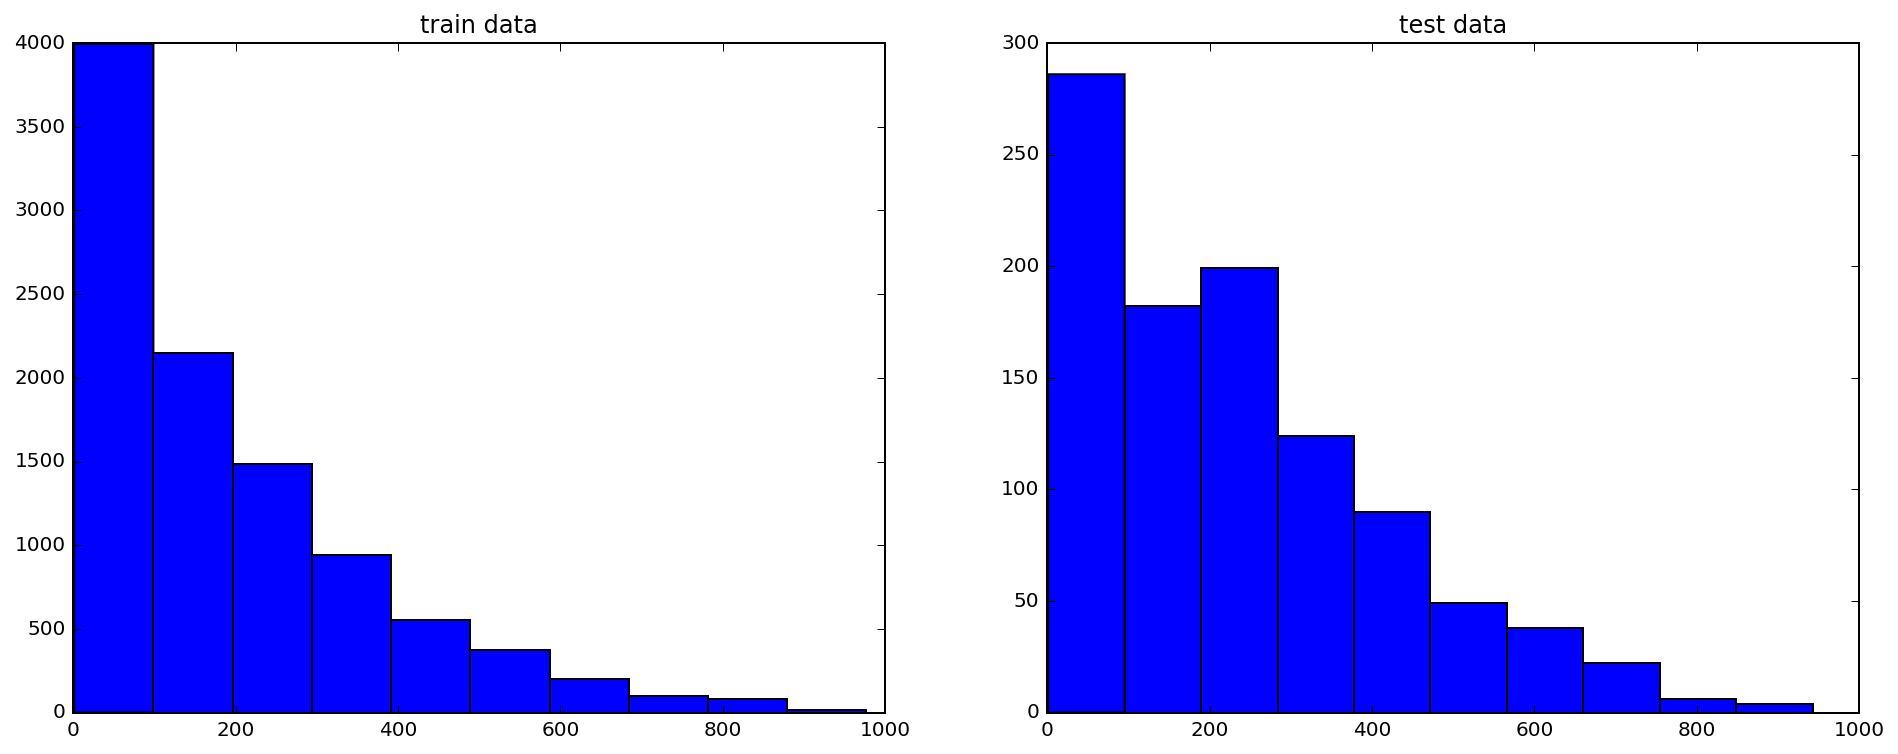

In [17]:
pylab.figure(figsize = (16, 6))

pylab.subplot(1,2,1)
pylab.hist(train_labels)
pylab.title('train data')

pylab.subplot(1,2,2)
pylab.hist(test_labels)
pylab.title('test data')

#### Числовые признаки

In [18]:
numeric_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'month', 'hour']

In [19]:
train_data = train_data[numeric_columns]
test_data = test_data[numeric_columns]

In [20]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0,3,13,1,0
1,9.02,13.635,80,0,8,32,1,1
2,9.02,13.635,80,0,5,27,1,2
3,9.84,14.395,75,0,3,10,1,3
4,9.84,14.395,75,0,0,1,1,4


In [21]:
test_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
9886,17.22,21.210,67,6.0032,20,505,10,7
9887,18.04,21.970,62,0.0000,35,800,10,8
9888,19.68,23.485,55,16.9979,32,323,10,9
9889,20.50,24.240,48,19.0012,65,157,10,10
9890,20.50,24.240,45,27.9993,56,172,10,11


### Модель

In [22]:
regressor = linear_model.SGDRegressor(random_state = 0)

In [55]:
regressor.get_params()

{'alpha': 0.0001,
 'average': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'n_iter': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': 0,
 'shuffle': True,
 'verbose': 0,
 'warm_start': False}

In [23]:
regressor.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(test_data))

34291115138178.953

In [24]:
print test_labels[:10]

[525 835 355 222 228 325 328 308 346 446]


In [25]:
print regressor.predict(test_data)[:10]

[  8.78217183e+13   1.35599874e+14   5.36003573e+13   1.97358521e+13
   2.27343721e+13   3.54305149e+13   3.64421304e+13   2.43694858e+13
   3.63676921e+13   5.23707167e+13]


In [26]:
regressor.coef_

array([  6.14437479e+10,   4.42635068e+10,   7.00770010e+10,
        -7.59442428e+10,  -1.55632061e+11,   1.69398831e+11,
        -5.26868159e+10,  -4.95660366e+10])

### Scaling

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
#создаем стандартный scaler
scaler = StandardScaler()
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [29]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

0.1179376296343151

In [30]:
print test_labels[:10]

[525 835 355 222 228 325 328 308 346 446]


In [31]:
print regressor.predict(scaled_test_data)[:10]

[ 524.82767322  834.83176277  354.85768824  221.89221002  227.84049612
  324.88196372  327.8982227   307.9347954   345.90146969  445.90141764]


### Подозрительно хорошо?

In [32]:
print regressor.coef_

[  1.41019246e+00  -1.40725539e+00   1.45346928e-02  -4.38984175e-02
   5.08589954e+01   1.48004811e+02  -8.23376876e-03   6.37720415e-03]


In [33]:
print map(lambda x : round(x, 2), regressor.coef_)

[1.41, -1.41, 0.01, -0.04, 50.86, 148.0, -0.01, 0.01]


In [34]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0,3,13,1,0
1,9.02,13.635,80,0,8,32,1,1
2,9.02,13.635,80,0,5,27,1,2
3,9.84,14.395,75,0,3,10,1,3
4,9.84,14.395,75,0,0,1,1,4


In [35]:
train_labels[:10]

array([16, 40, 32, 13,  1,  1,  2,  3,  8, 14])

In [36]:
np.all(train_data.registered + train_data.casual == train_labels)

True

In [37]:
train_data.drop(['casual', 'registered'], axis = 1, inplace = True)
test_data.drop(['casual', 'registered'], axis = 1, inplace = True)

In [38]:
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [39]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

121.81123864993025

In [40]:
print map(lambda x : round(x, 2), regressor.coef_)

[31.03, 29.96, -41.93, 6.17, 14.08, 49.6]


### Pipeline

In [41]:
from sklearn.pipeline import Pipeline

In [42]:
#создаем pipeline из двух шагов: scaling и классификация
pipeline = Pipeline(steps = [('scaling', scaler), ('regression', regressor)])

In [43]:
pipeline.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, pipeline.predict(test_data))

121.81123864993025

### Подбор параметров

In [44]:
pipeline.get_params().keys()

['regression__random_state',
 'regression__n_iter',
 'regression__epsilon',
 'regression__power_t',
 'regression__alpha',
 'regression__eta0',
 'regression__loss',
 'scaling',
 'steps',
 'scaling__copy',
 'regression__fit_intercept',
 'regression__warm_start',
 'regression__penalty',
 'regression__learning_rate',
 'regression__average',
 'regression__verbose',
 'regression__shuffle',
 'regression__l1_ratio',
 'regression',
 'scaling__with_std',
 'scaling__with_mean']

In [45]:
parameters_grid = {
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss', ],
    'regression__n_iter' : [3, 5, 10, 50], 
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5],
}

In [46]:
grid_cv = grid_search.GridSearchCV(pipeline, parameters_grid, scoring = 'mean_absolute_error', cv = 4)

In [47]:
%%time
grid_cv.fit(train_data, train_labels)

CPU times: user 16.7 s, sys: 30 ms, total: 16.8 s
Wall time: 16.8 s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=0, shuffle=True, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'regression__n_iter': [3, 5, 10, 50], 'regression__loss': ['huber', 'epsilon_insensitive', 'squared_loss'], 'scaling__with_mean': [0.0, 0.5], 'regression__alpha': [0.0001, 0.01], 'regression__penalty': ['l1', 'l2', 'none']},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [48]:
print grid_cv.best_score_
print grid_cv.best_params_

-108.614496603
{'regression__n_iter': 3, 'regression__loss': 'squared_loss', 'scaling__with_mean': 0.0, 'regression__alpha': 0.01, 'regression__penalty': 'l2'}


### Оценка по отложенному тесту

In [49]:
metrics.mean_absolute_error(test_labels, grid_cv.best_estimator_.predict(test_data))

119.98978845935379

In [50]:
np.mean(test_labels)

232.15899999999999

In [51]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [52]:
print test_labels[:10]

[525 835 355 222 228 325 328 308 346 446]


In [53]:
print test_predictions[:10]

[ 139.60470681  159.80765341  207.55935972  237.76288054  257.83836668
  267.44558034  272.49537469  297.70688522  304.29818873  313.58821156]


(-100, 1100)

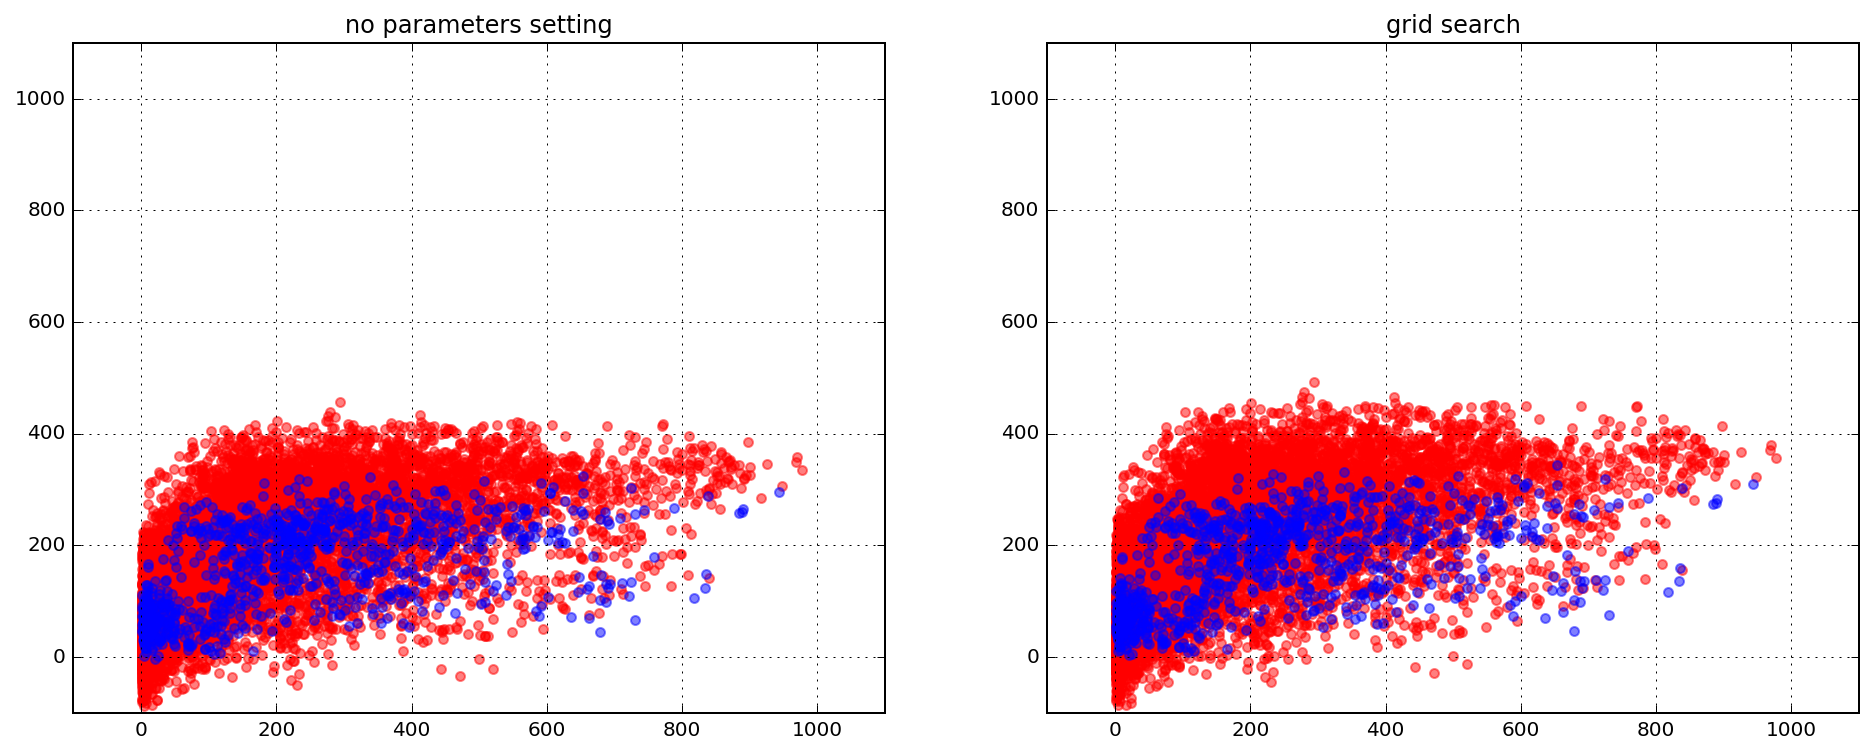

In [54]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.scatter(train_labels, pipeline.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, pipeline.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('no parameters setting')
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('grid search')
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)